In [1]:
import pandas as pd
import numpy as np
import random
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import streamlit as st
import joblib

In [2]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin1')
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [3]:
target_counts = df['0'].value_counts()
print(target_counts)

4    800000
0    799999
Name: 0, dtype: int64


As per data description, 0 is negative and 4 is positive

In [4]:
column_names = ['Target', 'ID', 'Date', 'Flag', 'User', 'Text']
total_rows = sum(1 for line in open('training.1600000.processed.noemoticon.csv', encoding='latin1'))

#Reducing dataset size as it is causing computation resources related issues
nrows = 50000
skiprows = sorted(random.sample(range(1, total_rows), total_rows - nrows))

df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin1', names=column_names, skiprows=skiprows)
df.head()


,Target,ID,Date,Flag,User,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467835305,Mon Apr 06 22:26:10 PDT 2009,NO_QUERY,MissLaura317,"@januarycrimson Sorry, babe!! My fam annoys m..."
2,0,1467837189,Mon Apr 06 22:26:38 PDT 2009,NO_QUERY,cityrat59,@mangaaa I hope they will increase the capacit...
3,0,1467839737,Mon Apr 06 22:27:21 PDT 2009,NO_QUERY,JenBah,Is pissed off that there's no ASBA's for a rad...
4,0,1467843734,Mon Apr 06 22:28:26 PDT 2009,NO_QUERY,chatpataa,my nokia 1110 died..


In [5]:
target_counts = df['Target'].value_counts()
print(target_counts)

0    25078
4    24922
Name: Target, dtype: int64


In [6]:
df = df[['Target', 'Text']]
df.dropna(inplace=True)

In [7]:
df['Text'] = df['Text'].apply(lambda x: x.lower())

df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

df['Text'] = df['Text'].apply(lambda x: word_tokenize(x))

stop_words = set(stopwords.words('english'))
df['Text'] = df['Text'].apply(lambda x: [word for word in x if word not in stop_words])

In [8]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nupur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Nupur\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:
lemmatizer = WordNetLemmatizer()
df['Text'] = df['Text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [11]:
df['Text']

0        [switchfoot, httptwitpiccom2y1zl, awww, thats,...
1        [januarycrimson, sorry, babe, fam, annoys, tha...
2        [mangaaa, hope, increase, capacity, fast, yest...
3                   [pissed, there, asbas, radio, station]
4                                      [nokia, 1110, died]
                               ...                        
49995                                [head, denmark, come]
49996    [hello, good, morning, wan, na, something, today]
49997    [mskcjones, yeah, irritating, right, god, side...
49998    [siovene, lol, dont, blame, safest, thing, world]
49999    [davepell, youre, undisputed, authority, topic...
Name: Text, Length: 50000, dtype: object

In [12]:
df['Text'] = df['Text'].apply(lambda x: ' '.join(x).lower())

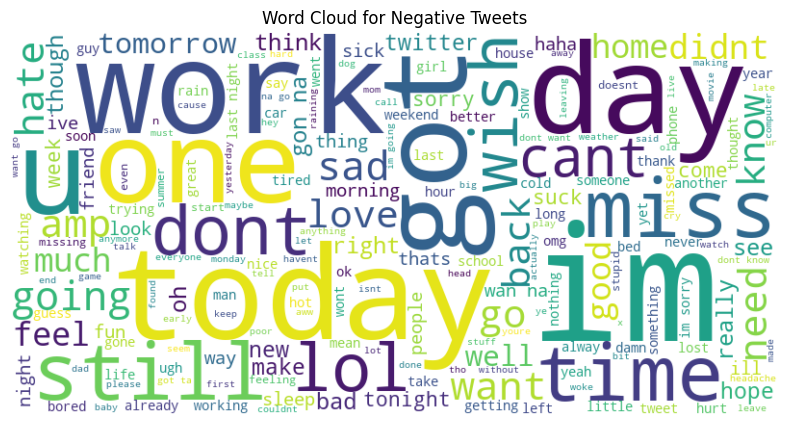

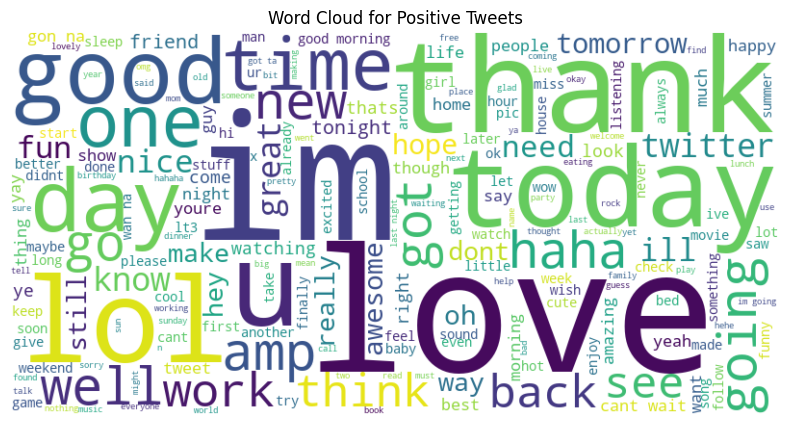

In [13]:
negative_tweets = df[df['Target'] == 0]['Text'].values
negative_text = ' '.join(negative_tweets)

negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Tweets')
plt.axis('off')
plt.show()

positive_tweets = df[df['Target'] == 4]['Text'].values
positive_text = ' '.join(positive_tweets)

positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Tweets')
plt.axis('off')
plt.show()


In [14]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['Text'])
y = df['Target']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [16]:
lr_model = LogisticRegression(max_iter=1000)  
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [17]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [18]:
lr_pred = lr_model.predict(X_test)
svm_pred = svm_model.predict(X_test)

lr_accuracy = accuracy_score(y_test, lr_pred)
svm_accuracy = accuracy_score(y_test, svm_pred)

print("Logistic Regression Accuracy:", lr_accuracy)
print("SVM Accuracy:", svm_accuracy)


Logistic Regression Accuracy: 0.75072
SVM Accuracy: 0.74664


In [19]:
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[^\w\s]', '', sentence)
    tokens = word_tokenize(sentence)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    processed_sentence = ' '.join(tokens)
    return processed_sentence

sentences = [
    "I had a great day today!",
    "I hated the service, it was terrible.",
    "The food was amazing, I highly recommend it.",
    "The product arrived late, disappointing",
    "The concert was crowded, I had a bad time."
]

processed_sentences = [preprocess_sentence(sentence) for sentence in sentences]

X_test_sentences = tfidf_vectorizer.transform(processed_sentences)

lr_predictions = lr_model.predict(X_test_sentences)

svm_predictions = svm_model.predict(X_test_sentences)

sentiment_map = {0: 'Negative', 4: 'Positive'}

print("Logistic Regression Predictions:")
for sentence, prediction in zip(sentences, lr_predictions):
    print(f"Sentence: {sentence} - Predicted Sentiment: {sentiment_map[prediction]}")

print("\nSVM Predictions:")
for sentence, prediction in zip(sentences, svm_predictions):
    print(f"Sentence: {sentence} - Predicted Sentiment: {sentiment_map[prediction]}")


Logistic Regression Predictions:
Sentence: I had a great day today! - Predicted Sentiment: Positive
Sentence: I hated the service, it was terrible. - Predicted Sentiment: Negative
Sentence: The food was amazing, I highly recommend it. - Predicted Sentiment: Positive
Sentence: The product arrived late, disappointing - Predicted Sentiment: Negative
Sentence: The concert was crowded, I had a bad time. - Predicted Sentiment: Negative

SVM Predictions:
Sentence: I had a great day today! - Predicted Sentiment: Positive
Sentence: I hated the service, it was terrible. - Predicted Sentiment: Negative
Sentence: The food was amazing, I highly recommend it. - Predicted Sentiment: Positive
Sentence: The product arrived late, disappointing - Predicted Sentiment: Negative
Sentence: The concert was crowded, I had a bad time. - Predicted Sentiment: Negative


In [20]:
lr_model = LogisticRegression()
svm_model = SVC()
joblib.dump(lr_model, 'lr_model.pkl')
joblib.dump(svm_model, 'svm_model.pkl')

['svm_model.pkl']